In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

In [2]:
fb15k_237 = np.load('./data/fb15k_237.npz', allow_pickle=True)

In [3]:
fb_train = fb15k_237['train']
fb_valid = fb15k_237['valid']
fb_test = fb15k_237['test']

In [37]:
entities = set(np.concatenate((fb_train[:,0], fb_train[:,2]), axis=0))
all_relations = set(fb_train[:,1])

num_entities = len(entities)
num_relations = len(all_relations)

ent2idx = dict(zip(entities, range(num_entities)))
rel2idx = dict(zip(all_relations, range(num_relations)))

idx2ent = {idx:ent for ent,idx in ent2idx.items()}
idx2rel = {idx:rel for rel,idx in rel2idx.items()}

In [5]:
train2idx = []

for head, rel, tail in fb_train:
    
    head_idx = ent2idx[head]
    tail_idx = ent2idx[tail]
    rel_idx = rel2idx[rel]

    train2idx.append([head_idx, rel_idx, tail_idx])
    
train2idx = np.array(train2idx)

In [6]:
valid2idx = []

for head, rel, tail in fb_valid:
    
    head_idx = ent2idx[head]
    tail_idx = ent2idx[tail]
    rel_idx = rel2idx[rel]

    valid2idx.append([head_idx, rel_idx, tail_idx])
    
valid2idx = np.array(valid2idx)

In [7]:
EMBEDDING_SIZE = 10
BATCH_SIZE = 128
NUM_EPOCHS = 2
MARGIN = 2
SQRT_SIZE = 6 / np.sqrt(EMBEDDING_SIZE)

pos_head_input = tf.keras.layers.Input(shape=(1,), name='pos_head_input')
neg_head_input = tf.keras.layers.Input(shape=(1,), name='neg_head_input')
pos_tail_input = tf.keras.layers.Input(shape=(1,), name='pos_tail_input')
neg_tail_input = tf.keras.layers.Input(shape=(1,), name='neg_tail_input')
relation_input = tf.keras.layers.Input(shape=(1,), name='relation_input')

entity_embedding = tf.keras.layers.Embedding(
    input_dim=num_entities,
    output_dim=EMBEDDING_SIZE,
    name='entity_embeddings',
    #embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
    #embeddings_regularizer=tf.keras.regularizers.l2(.01)
    )

relation_embedding = tf.keras.layers.Embedding(
    input_dim=num_relations,
    output_dim=EMBEDDING_SIZE,
    name='relation_embeddings',
    #embeddings_initializer=tf.keras.initializers.RandomUniform(minval=-SQRT_SIZE, maxval=SQRT_SIZE, seed=123)
    #embeddings_regularizer=tf.keras.regularizers.l2(.01)
    )

pos_head_e = entity_embedding(pos_head_input)
neg_head_e = entity_embedding(neg_head_input)
pos_tail_e = entity_embedding(pos_tail_input)
neg_tail_e = entity_embedding(neg_tail_input)
rel_e = relation_embedding(relation_input)

In [8]:
model = tf.keras.models.Model(
    inputs=[
        pos_head_input,
        neg_head_input, 
        pos_tail_input, 
        neg_tail_input, 
        relation_input
        ], 
    outputs=[
        pos_head_e,
        neg_head_e, 
        pos_tail_e, 
        neg_tail_e, 
        rel_e
        ]
    )

In [9]:
# ent_shape = (num_entities, EMBEDDING_SIZE)
# rel_shape = (num_relations, EMBEDDING_SIZE)

# sqrt_size = 6 / np.sqrt(EMBEDDING_SIZE)

# ent_embeddings = tf.Variable(
#     initial_value=tf.random.uniform(shape=ent_shape, minval=-sqrt_size, maxval=sqrt_size), 
#     trainable=True, 
#     shape=ent_shape
#     )

# rel_embeddings = tf.Variable(
#     initial_value=tf.random.uniform(shape=rel_shape, minval=-sqrt_size, maxval=sqrt_size), 
#     trainable=True, 
#     shape=rel_shape
#     )

In [10]:
def get_negative_triples(head, rel, tail):
    
    cond = tf.random.uniform(head.shape, 0, 2, dtype=tf.int64) #1 means keep entity
    rnd = tf.random.uniform(head.shape, 0, num_entities-1, dtype=tf.int64)
    
    neg_head = tf.where(cond == 1, head, rnd)
    neg_tail = tf.where(cond == 1, rnd, tail)   
    
    return neg_head, neg_tail

train_data = tf.data.Dataset.from_tensor_slices((train2idx[:,0], train2idx[:,1], train2idx[:,2]))
train_data = train_data.shuffle(buffer_size=50000).batch(BATCH_SIZE)

#exp_decay = tf.keras.optimizers.schedules.ExponentialDecay(.01, 1000, .05)
optimizer = tf.keras.optimizers.SGD(learning_rate=.01)

In [11]:
# for epoch in range(10):
    
#     for head, rel, tail in train_data:
        
#         neg_head, neg_tail = get_negative_triples(head, rel, tail)

#         with tf.GradientTape() as tape:

#             pos_h_e = tf.nn.embedding_lookup(ent_embeddings,head)
#             pos_t_e = tf.nn.embedding_lookup(ent_embeddings,tail)
#             pos_r_e = tf.nn.embedding_lookup(rel_embeddings,rel)

#             neg_h_e = tf.nn.embedding_lookup(ent_embeddings,neg_head)
#             neg_t_e = tf.nn.embedding_lookup(ent_embeddings,neg_tail)
#             neg_r_e = tf.nn.embedding_lookup(rel_embeddings,rel)

#             pos = tf.reduce_sum(tf.square(pos_h_e + pos_r_e - pos_t_e), axis=1, keepdims=True)
#             neg = tf.reduce_sum(tf.square(neg_h_e + neg_r_e - neg_t_e), axis=1, keepdims=True)    

#             embedding_loss = tf.reduce_sum(tf.maximum(pos - neg + MARGIN, 0))
        
#         transE_grads = tape.gradient(embedding_loss,[ent_embeddings, rel_embeddings])

#         optimizer.apply_gradients(zip(transE_grads, [ent_embeddings, rel_embeddings]))
        
#     print('Current loss ', embedding_loss.numpy())

In [12]:
count = 0
losses = []

for epoch in range(100):
    
    for head, rel, tail in train_data:
                
        neg_head, neg_tail = get_negative_triples(head, rel, tail)
        
        with tf.GradientTape() as tape:
            
            pos_head_e,neg_head_e, pos_tail_e, neg_tail_e, rel_e = model([head, neg_head, tail, neg_tail, rel])
            
            pos = tf.reduce_sum(tf.square(pos_head_e + rel_e - pos_tail_e), axis=1, keepdims=True)
            neg = tf.reduce_sum(tf.square(neg_head_e + rel_e - neg_tail_e), axis=1, keepdims=True)    

            embedding_loss = tf.reduce_sum(tf.maximum(pos - neg + MARGIN, 0))
            
        grads = tape.gradient(embedding_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    if not epoch % 10:
        
        print('Current loss' , embedding_loss.numpy(),'at epoch', epoch)
    
    losses.append(embedding_loss.numpy())

Current loss 114.58287 at epoch 0
Current loss 15.958589 at epoch 10
Current loss 7.7476616 at epoch 20
Current loss 4.9922533 at epoch 30
Current loss 4.47339 at epoch 40
Current loss 21.619081 at epoch 50
Current loss 18.378769 at epoch 60
Current loss 4.1986165 at epoch 70
Current loss 7.5372167 at epoch 80
Current loss 14.0245285 at epoch 90


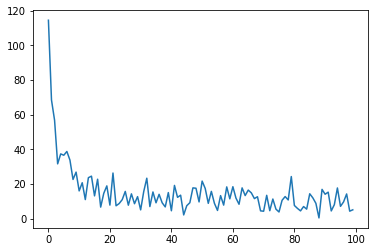

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [27]:
embeddings = model.get_layer('entity_embeddings').get_weights()[0]
relations = model.get_layer('relation_embeddings').get_weights()[0]

In [68]:
head, tail = embeddings[[14, 6], :]

-np.linalg.norm((head+relations[12] - tail),ord=2)

-7.3958592